In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from python_speech_features import mfcc
import scipy.io.wavfile as wav

# Gaussian Mixture Models

The k-means clustering model is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application. In particular, the non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations. In this section we will take a look at Gaussian Mixture Models (GMMs), which can be viewed as an extension of the ideas behind k-means, but can also be a powerful tool for estimation beyond simple clustering - in fact, we will see how it can be used to help build powerful classification algorithms.

## Weaknesses of k-Means
Let's take a look at some of the weaknesses of k-means and think about how we might improve the cluster model. As we saw in the previous lectures, given simple, well-separated data, k-means finds suitable clustering results.

For example, if we have simple blobs of data, the k-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

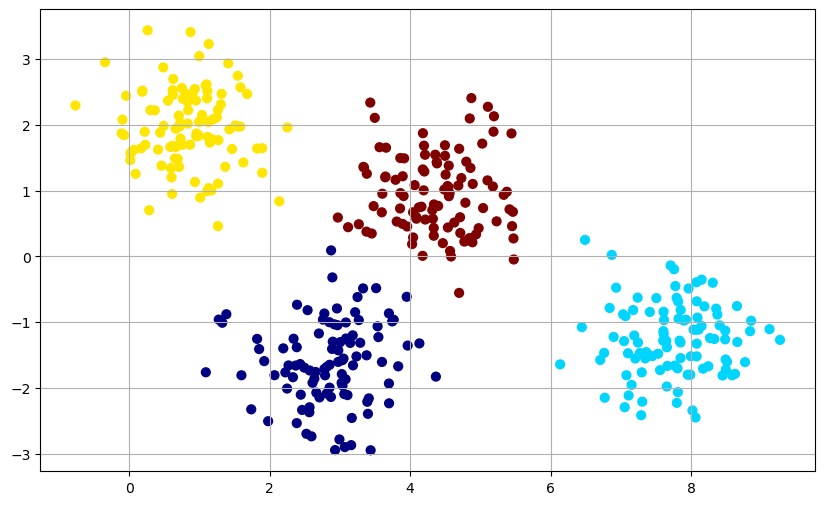

In [2]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
fig, gmm1 = plt.subplots(figsize=(10, 6))
gmm1.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');
gmm1.grid()

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them. Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments. For this, we must think about generalizing the model.

One way to think about the k-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster. This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster. We can visualize this cluster model with the following function:

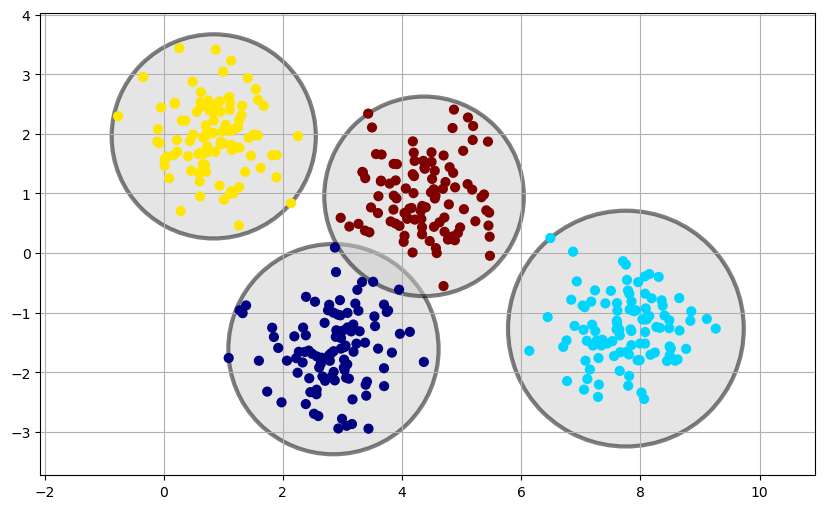

In [3]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.grid()
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', ec='black', lw=3, alpha=0.5, zorder=1))
        
fig, gmm2 = plt.subplots(figsize=(10, 6))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X, ax=gmm2)

An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters. So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

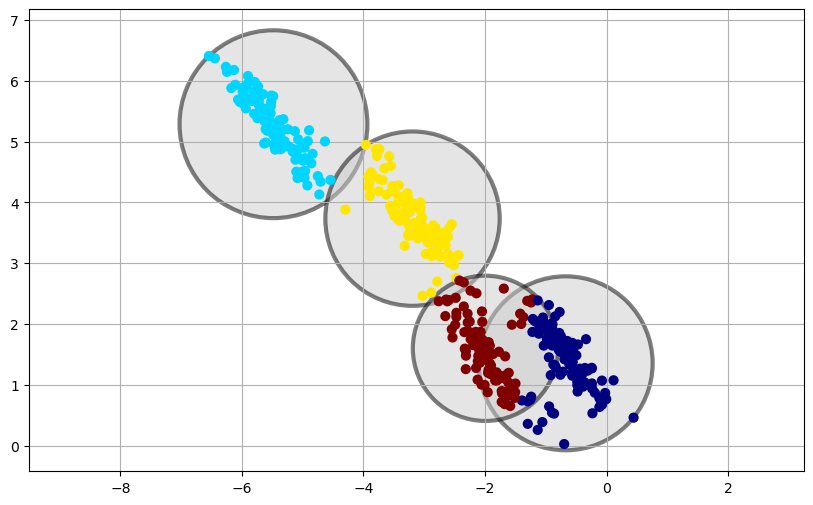

In [4]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

fig, gmm3 = plt.subplots(figsize=(10, 6))
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched, ax=gmm3)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit. Nevertheless, k-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters. This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.

These two disadvantages of k-means — its lack of flexibility in cluster shape and lack of probabilistic cluster assignment — mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the k-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to all cluster centers, rather than focusing on just the closest. You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters. It turns out these are two essential components of a different type of clustering model, Gaussian Mixture Models.

## Expectation-Maximization
A GMM attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means:

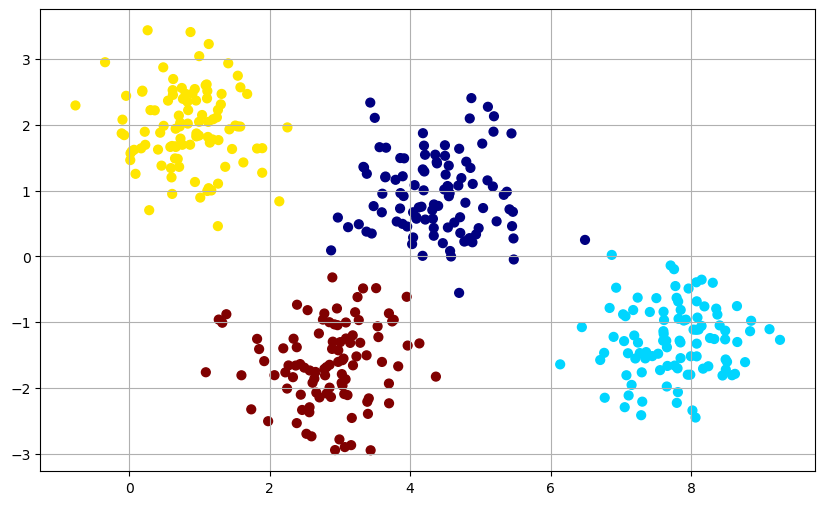

In [5]:
from sklearn.mixture import GaussianMixture as GMM

gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)

fig, gmm4 = plt.subplots(figsize=(10, 6))
gmm4.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet');
gmm4.grid()

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments — in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster:

In [6]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.537 0.463 0.    0.   ]
 [0.    0.    0.    1.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]]


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

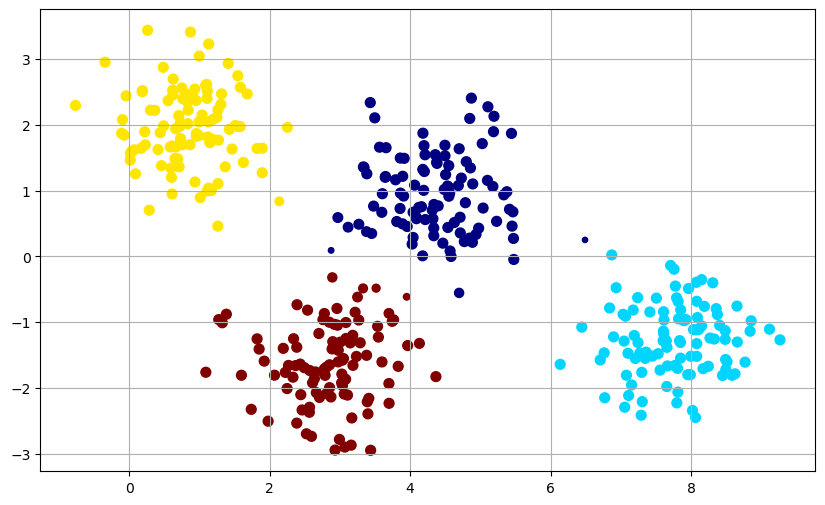

In [7]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences

fig, gmm5 = plt.subplots(figsize=(10, 6))
gmm5.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet', s=size);
gmm5.grid()

Under the hood, a GMM is very similar to k-means: it uses an Expectation–Maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape<br>
2. Repeat until converged:<br>
    2.1 E-step: for each point, find weights encoding the probability of membership in each cluster<br>
    2.2 M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights<br>

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. Just as in the k-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [8]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='jet', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    ax.grid()

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

/var/folders/gj/064s2v8d0rvdkvk7crlz54tw0000gn/T/ipykernel_1975/1932780032.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


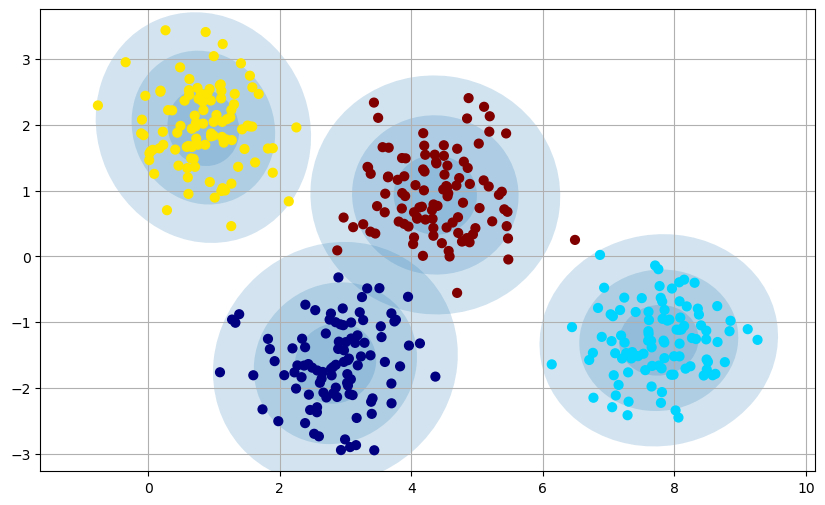

In [9]:
gmm = GMM(n_components=4)

fig, gmm6 = plt.subplots(figsize=(10, 6))
plot_gmm(gmm, X, ax=gmm6)
plt.show()

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

/var/folders/gj/064s2v8d0rvdkvk7crlz54tw0000gn/T/ipykernel_1975/1932780032.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


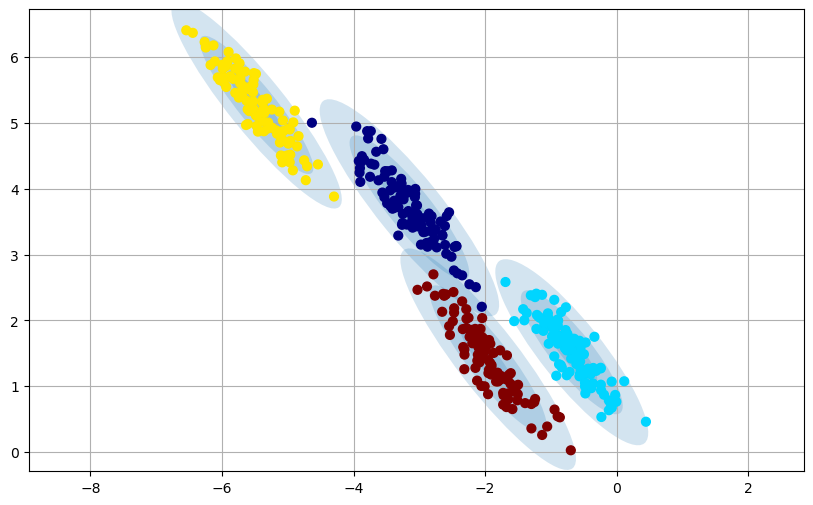

In [10]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

fig, gmm6 = plt.subplots(figsize=(10, 6))
gmm = GMM(n_components=4, covariance_type='full')
plot_gmm(gmm, X_stretched, ax=gmm6)

This makes clear that GMM addresses the two main practical issues with k-means encountered before.

## Choosing the Covariance Type
If you look at the details of the preceding fits, you will see that the covariance_type option was set differently within each. This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem. The default is covariance_type="diag", which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes. A slightly simpler and faster model is covariance_type="spherical", which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of k-means, though it is not entirely equivalent. A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use covariance_type="full", which allows each cluster to be modeled as an ellipse with arbitrary orientation. To visualize all of this, have a look at how different covariance types model the data differently:

<img src="img/covariance-type.png" width="1024">

## GMM as Density Estimation
Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's make_moons function:

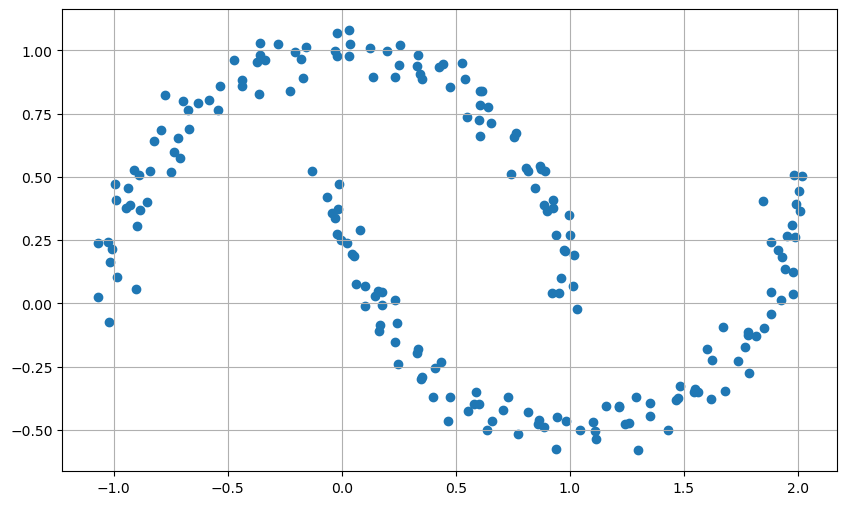

In [11]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
fig, gmm7 = plt.subplots(figsize=(10, 6))
gmm7.scatter(Xmoon[:, 0], Xmoon[:, 1]);
gmm7.grid()

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

/var/folders/gj/064s2v8d0rvdkvk7crlz54tw0000gn/T/ipykernel_1975/1932780032.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


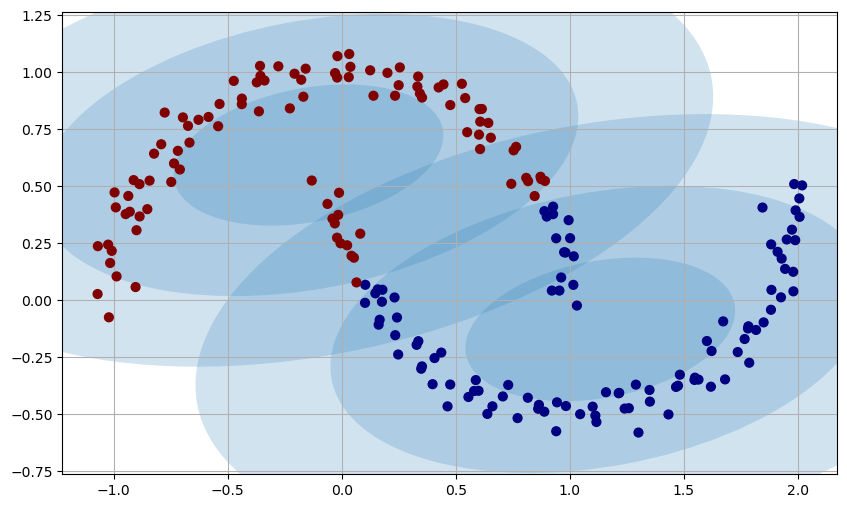

In [12]:
gmm2_clusters = GMM(n_components=2, covariance_type='full')

fig, gmm8 = plt.subplots(figsize=(10, 6))
plot_gmm(gmm2_clusters, Xmoon, ax=gmm8)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

/var/folders/gj/064s2v8d0rvdkvk7crlz54tw0000gn/T/ipykernel_1975/1932780032.py:18: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ax.add_patch(Ellipse(position, nsig * width, nsig * height,


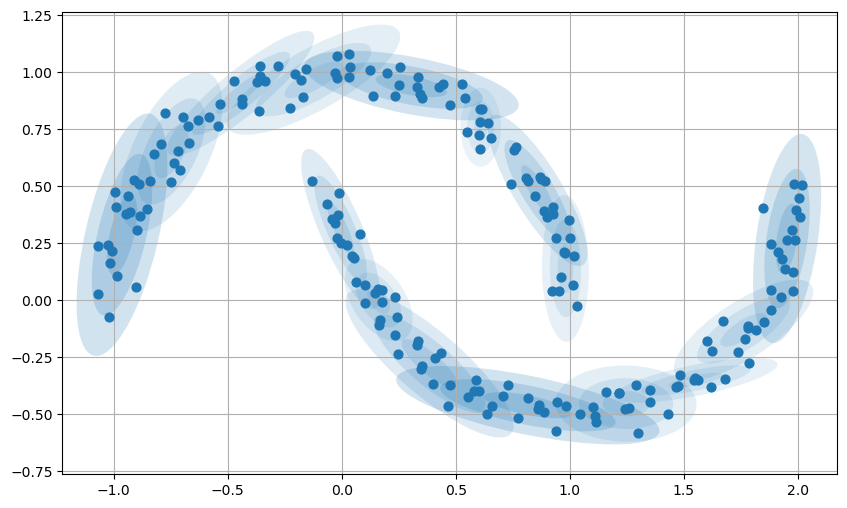

In [13]:
gmm16_clusters = GMM(n_components=16, covariance_type='full')

fig, gmm9 = plt.subplots(figsize=(10, 6))
plot_gmm(gmm16_clusters, Xmoon, label=False, ax=gmm9)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

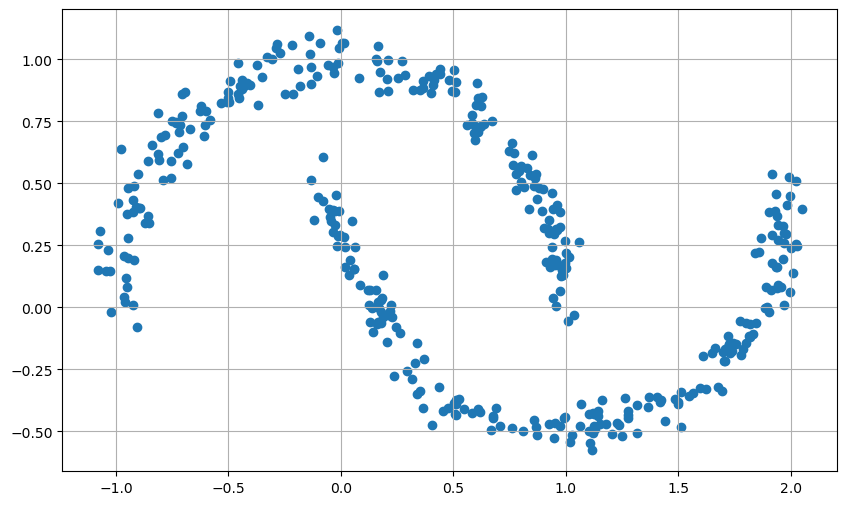

In [14]:
Xnew = gmm16_clusters.sample(400)[0]

fig, gmm10 = plt.subplots(figsize=(10, 6))
gmm10.scatter(Xnew[:, 0], Xnew[:, 1]);
gmm10.grid()

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

## How Many Components?
You may recall a problem with k-Means clustering - picking the right value of 'K'. The same problem is present in GMM estimation - picking the right number of components to make up the mixture model. We do have one advantage over k-Means with GMMs.

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset. A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the likelihood of the data under the model, using cross-validation to avoid over-fitting. Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the <b>Akaike information criterion</b> (AIC) or the <b>Bayesian information criterion</b> (BIC). Scikit-Learn's GMM estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

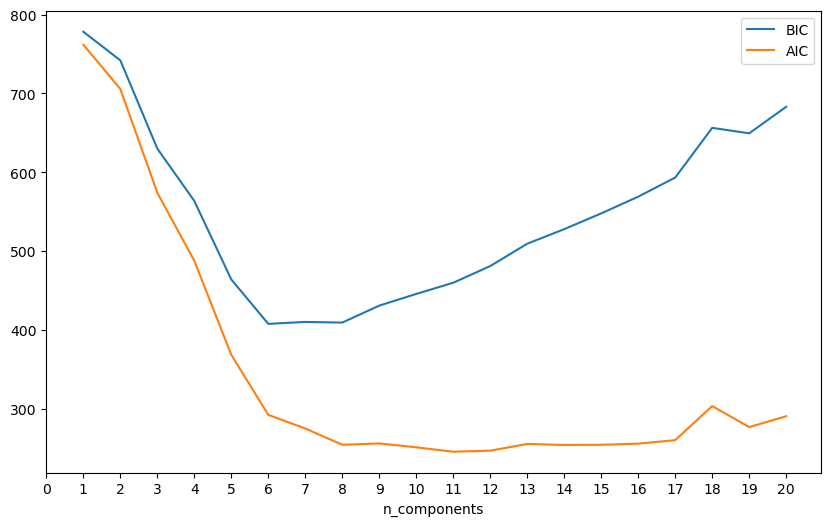

In [15]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

fig, gmm11 = plt.subplots(figsize=(10, 6))
gmm11.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
gmm11.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
gmm11.legend(loc='best')
gmm11.set_xlabel('n_components')
gmm11.set_xticks(np.arange(0, 21, 1));

The optimal number of clusters is the value that <b>minimizes</b> the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice. As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works as a density estimator, not how well it works as a clustering algorithm. I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Rewind: Classification
Now that we know how to create GMMs to represent 'complex' distributions of data, we can also think about how it it possible to use GMMs as a tool for classification. If we have labelled samples of data for a variety of classes, and each class has some 'complex' density form (such as the moons data above), then we could technically build a GMM for every class, and use those GMMs to then give us a probabilistic reading of whether a test sample was 'generated' from that GMM i.e. a likelihood that the sample would be something you would <b>normally expect</b> from a GMM. The class model that gives us the best likelihood would give us a classification result.

Recalle our first method of clssification: Gaussian Naive Bayes classification. The concept here was to describe each class by a single Gaussian of a particular mean and standard deviation. Later on we saw how this model, though simple to create, is not sufficient for more complex, real-world problems, where classes can have data distributions that do not necessarily have a normal distribution.

We have just developed a very powerful density estimator with GMMs - so what if we could do something similar to Gaussian Naive Bayes, utilising a GMM for each class, as opposed to a single Gaussian? Well, we can. With a more flexible model for the probability distribution, we could more closely model the true distributions and improve on our ability to classify the sources. We will call this technique <b>GMM Bayes Classifier</b>, for lack of a standard term.

Each of the components may be constrained to a simple case (such as diagonal-covariance-only Gaussians etc.) to ease the computational cost of model fitting. Note that the number of Gaussian components K must be chosen, ideally, for each class independently, in addition to the cost of model fitting for each value of K tried. A GMM Bayes classifier is not included in Scikit-Learn, but we can create one for ourselves:

In [16]:
"""
GMM Bayes
---------
This implements generative classification based on mixtures of gaussians
to model the probability density of each class.
"""

import warnings
import numpy as np

from sklearn.naive_bayes import GaussianNB
from sklearn.mixture import GaussianMixture


class GMMBayes(GaussianNB):
    """GaussianMixture Bayes Classifier

    This is a generalization to the Naive Bayes classifier: rather than
    modeling the distribution of each class with axis-aligned gaussians,
    GMMBayes models the distribution of each class with mixtures of
    gaussians.  This can lead to better classification in some cases.

    Parameters
    ----------
    n_components : int or list
        number of components to use in the GaussianMixture. If specified as
        a list, it must match the number of class labels. Default is 1.
    **kwargs : dict, optional
        other keywords are passed directly to GaussianMixture
    """

    def __init__(self, n_components=1, **kwargs):
        self.n_components = np.atleast_1d(n_components)
        self.kwargs = kwargs


    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)

        n_samples, n_features = X.shape

        if n_samples != y.shape[0]:
            raise ValueError("X and y have incompatible shapes")

        self.classes_ = np.unique(y)
        self.classes_.sort()
        unique_y = self.classes_

        n_classes = unique_y.shape[0]

        if self.n_components.size not in (1, len(unique_y)):
            raise ValueError("n_components must be compatible with "
                             "the number of classes")

        self.gmms_ = [None for i in range(n_classes)]
        self.class_prior_ = np.zeros(n_classes)

        n_comp = np.zeros(len(self.classes_), dtype=int) + self.n_components

        for i, y_i in enumerate(unique_y):
            if n_comp[i] > X[y == y_i].shape[0]:
                warnstr = ("Expected n_samples >= n_components but got "
                           "n_samples={0}, n_components={1}, "
                           "n_components set to {0}.")
                warnings.warn(warnstr.format(X[y == y_i].shape[0], n_comp[i]))
                n_comp[i] = y_i
            self.gmms_[i] = GaussianMixture(n_comp[i], **self.kwargs).fit(X[y == y_i])
            self.class_prior_[i] = float(np.sum(y == y_i)) / n_samples

        return self

    def _joint_log_likelihood(self, X):

        X = np.asarray(np.atleast_2d(X))
        logprobs = np.array([g.score_samples(X) for g in self.gmms_]).T
        return logprobs + np.log(self.class_prior_)

In [17]:
# Load up dataset
(rate,sig) = wav.read('test/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)

(rate,sig) = wav.read('test/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)

labels_female = np.zeros((len(mfcc_feat_female),1))
labels_male = np.ones((len(mfcc_feat_male),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# Fit the NGMM aive Bayes classifier to all original dimensions
gmm_nb = GMMBayes(128) # 128 components per class
gmm_nb.fit(samples, labels)

# now predict
labels_pred = gmm_nb.predict(samples)

# Classification report
print(classification_report(labels, labels_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      4950
         1.0       1.00      1.00      1.00      8192

    accuracy                           1.00     13142
   macro avg       1.00      1.00      1.00     13142
weighted avg       1.00      1.00      1.00     13142



This demonstrates how powerful GMMs are as density estimators. Let us also look at the classification contour for this model:

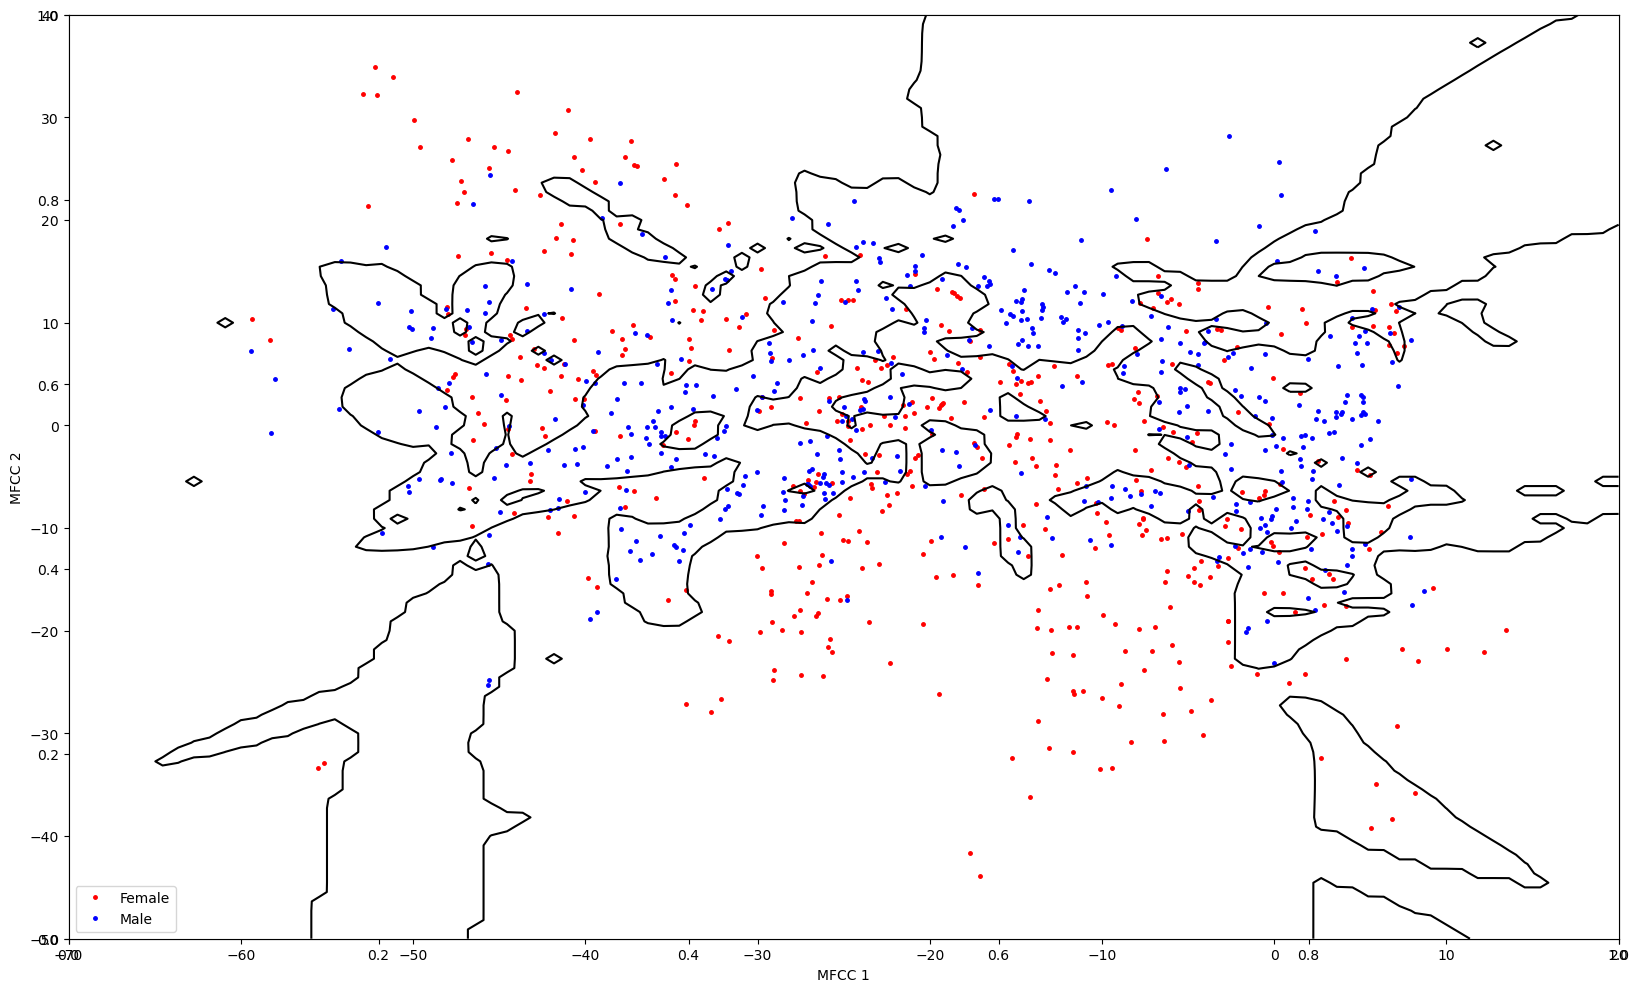

In [18]:
# Load up dataset
(rate,sig) = wav.read('test/female.wav')
mfcc_feat_female = mfcc(sig,rate,nfft=1024)
mfcc_feat_female = mfcc_feat_female[0:500,:] # first 500 points
mfcc_feat_female_2d = mfcc_feat_female[:,1:3] # first 2 dimensions

(rate,sig) = wav.read('test/male.wav')
mfcc_feat_male = mfcc(sig,rate,nfft=1024)
mfcc_feat_male = mfcc_feat_male[0:500,:] # first 500 points
mfcc_feat_male_2d = mfcc_feat_male[:,1:3] #first 2 dimensions

labels_female = np.zeros((len(mfcc_feat_female_2d),1))
labels_male = np.ones((len(mfcc_feat_male_2d),1))

samples = np.concatenate((mfcc_feat_female,mfcc_feat_male))
samples_2d = np.concatenate((mfcc_feat_female_2d,mfcc_feat_male_2d))
labels = np.ravel(np.concatenate((labels_female,labels_male)))

# Fit the GMM Naive Bayes classifier to all original dimensions
gmm_nb = GMMBayes(128) # 128 components per class
gmm_nb.fit(samples_2d, labels)

# predict the classification probabilities on a grid
xlim = (-70, 20)
ylim = (-50, 40)
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))

#convert to 1-D arrays
oned_xx = xx.ravel()
oned_yy = yy.ravel()

# get probabilities of each x,y coordinate from the NB classifier
# i.e. returns the probability of the samples for each class in the model. 
Z = gmm_nb.predict_proba(np.column_stack((oned_xx,oned_yy)))
Z = Z[:, 1].reshape(xx.shape)

# Plot the samples again
fig, ax_gmm_nb = plt.subplots(figsize=(20, 12))
ax_gmm_nb = plt.axes()
ax_gmm_nb.plot(samples_2d[(labels==0),0], samples_2d[(labels==0),1], '.', ms=5, c='r', label='Female')
ax_gmm_nb.plot(samples_2d[(labels==1),0], samples_2d[(labels==1),1], '.', ms=5, c='b', label='Male')

ax_gmm_nb.legend(loc=3)
ax_gmm_nb.set_xlabel('MFCC 1')
ax_gmm_nb.set_ylabel('MFCC 2')

# Now plot the contour between the two classes at p=0.5
# i.e. for every coordinate in xx,yy, if z is at 0.5 
# (equal probability) of both classes, then draw the contour at that coordinate
ax_gmm_nb.contour(xx, yy, Z, [0.5], colors='k')

plt.show()

Notice how we do not have a single classification contour, but many. The GMM modelling of each class has managed to isolate localised clusters of data points for the two classes (hence why the contamination score is low). The Naive Bayes model is now a lot more powerful with GMMs in the mix! You may be curious as to how a GMM Naive Bayes classifier stacks up with all the other classifiers we looked at in our earlier lectures, but that's an analysis left up to you when coding up your assignment!